In [1]:
import numpy as np
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta, datetime


sns.set_theme()
sns.set_palette("colorblind")
measurements_file = 'measurements.csv'
contracts_file = 'Contracts.csv'
palette = sns.color_palette('colorblind')
%matplotlib widget

# Data Loading
### Measurements

In [2]:
measure_df = pd.read_csv(measurements_file)
measure_df['date'] = pd.to_datetime(measure_df['date'])
measure_df.sort_values(by='date', inplace=True)
measure_df.tail()\

,aggregate_consumption,date,measure_unit,contract,photo
132,27804.700,2022-09-29 18:58:03,m3,GasKar39-21,16644706727125167921213744981747.jpg
135,39600.500,2022-10-08 21:13:21,kWh,StromKar39-21,16652563947772299379751595241442.jpg
136,27825.127,2022-10-08 21:14:26,m3,GasKar39-21,16652564602848028236367888626448.jpg
137,39611.800,2022-10-10 17:09:34,kWh,StromKar39-21,1665414566938761018297631924558.jpg
138,27829.233,2022-10-10 17:10:13,m3,GasKar39-21,16654146080863718670782700242985.jpg


### Contracts

In [3]:
contract_df = pd.read_csv(contracts_file)
contract_df.tail()

,ID,ContractName,Type,Address,ContractYear,From,To,Contractor,VAT%,Currency,...,Price/Unit,Price/Unit+VAT,BasePrice/Month,BasePrice/Month+VAT,Reserved-Unit,Price/Month,TotalPrice,Months,Bonus,Extras
2,StromJak138-20/1,StromJak138-20,Strom,Jakobstraße 138 1.OG,2020,01.10.2020,31.12.2020,Vattenfall,16,EUR,...,0.2436,0.2826,8.681034,10.07,1000.0,73.0,146.0,2,[170],NaN
3,StromJak138-20/2,StromJak138-20,Strom,Jakobstraße 138 1.OG,2020,01.01.2021,30.09.2021,Vattenfall,19,EUR,...,0.2436,0.2899,9.798319,11.66,2000.0,73.0,657.0,9,[145],NaN
4,GasJak138-20,GasJak138-20,Gas,Jakobstraße 138 1.OG,2020,01.10.2020,30.09.2021,Unknown,19,EUR,...,0.0622,0.0740,13.420000,15.97,NaN,NaN,NaN,24,[],NaN
5,StromKar39-21,StromKar39-21,Strom,Karlsgraben 39 EG,2021,01.10.2021,10.10.2022,Vattenfall,19,EUR,...,0.2476,0.2947,10.731092,12.77,2500.0,80.0,880.0,11,"[20,42]",Thermo Knob 139.99
6,GasKar39-21,GasKar39-21,Gas,Karlsgraben 39 EG,2021,01.10.2021,10.10.2022,Vattenfall,19,EUR,...,0.0689,0.0820,13.420000,15.97,12000.0,100.0,1100.0,11,"[20,173]",Thermo Knob 139.99


# Data Preparation
*Note:* Please skip this section if you are only interested in insights.

In [4]:
df = measure_df
# Transform all measure units to kWh
df.loc[df['measure_unit'] == 'mWh', 'aggregate_consumption'] *= 1000
df.loc[df['measure_unit'] == 'mWh', 'measure_unit'] = 'kWh'

df.loc[df['measure_unit'] == 'm3', 'aggregate_consumption'] *= 10.6
df.loc[df['measure_unit'] == 'm3', 'measure_unit'] = 'kWh'

# Join with contracts to expand information for each measurement.
df = df.merge(contract_df, left_on='contract', right_on='ID', sort=False)

# Order by date. IMPORTANT!!!
df.sort_values(by='date', inplace=True, ignore_index=True)

# Handle meter changes (restart of the counter). For each address and type of metters.
df["TypeAddress"] = df['Type'] + " - " + df['Address']

for meter in df["TypeAddress"].unique():
    zeros = df.index[(df['TypeAddress'] == meter) & (df['aggregate_consumption'] == 0)]
    for zero in np.flip(zeros):
        zeros_mask = np.zeros(df.shape[0])
        zeros_mask[zero:] = 1
        df.loc[(df['TypeAddress'] == meter) & zeros_mask, 'aggregate_consumption'] += df['aggregate_consumption'][zero - 1]
        
# Interpolate measures for each contract to acquire more points
# TODO: change this code with linear regression.
dfs = []
for contract_id in df['ID'].unique():
    cdf = df[df['ID'] == contract_id]
    x = cdf['date'].values.astype('int64') // 10**9
    y = cdf['aggregate_consumption']
    f = interpolate.interp1d(x, y, kind='linear')
    
    sdate = cdf['date'].min().date() + timedelta(days=1)   # start date
    edate = cdf['date'].max().date()   # end date

    delta = edate - sdate       # as timedelta
    dates = [sdate + timedelta(days=i) for i in range(delta.days + 1)]
    xnew = np.array(pd.to_datetime(dates).values.astype('int64') // 10**9)
    ynew = f(xnew)
    datesnew = pd.to_datetime(xnew * 10**9)
    new_df = pd.DataFrame({'aggregate_consumption': ynew, 'date': datesnew, 'measure_unit': 'kWh', 'contract': contract_id})
    dfs.append(new_df)

df = pd.concat(dfs, axis=0)
df = df.merge(contract_df, left_on='contract', right_on='ID', sort=False)
df.sort_values(by='date', inplace=True, ignore_index=True)
df["TypeAddress"] = df['Type'] + " - " + df['Address']

# Calculate consumption
df['consumption'] = 0
for meter in df["TypeAddress"].unique():
    meter_df = df[df['TypeAddress'] == meter].copy()
    aggregate_consumption = meter_df.aggregate_consumption.to_numpy()
    aggregate_consumption_shifted = np.concatenate(([aggregate_consumption[0]], aggregate_consumption))[0:-1]
    df.loc[df['TypeAddress'] == meter, 'consumption'] = (aggregate_consumption - aggregate_consumption_shifted).clip(min=0)    

# Prepare data by splitting it on contract (annual basis)
df['original_date'] = df['date']
annual_df = df.copy()
min_contract_year = annual_df['ContractYear'].min()

for contract_name in annual_df['ContractName'].unique():
    year = contract_df[contract_df['ContractName'] == contract_name]['ContractYear'].min()
    annual_df.loc[annual_df['ContractName'] == contract_name, 'date'] -= pd.offsets.DateOffset(years=(year - min_contract_year))
    annual_df.loc[annual_df['ContractName'] == contract_name, 'aggregate_consumption'] -= annual_df[annual_df['ContractName'] == contract_name]['aggregate_consumption'].min()

# Insights
## Strom

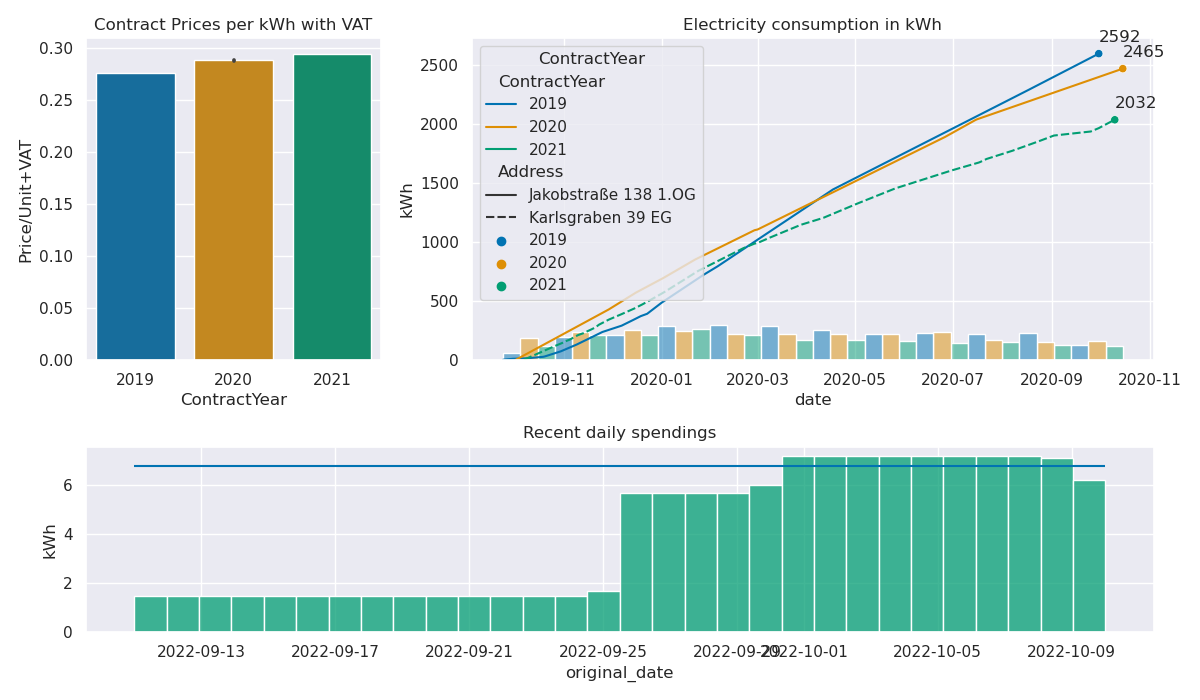

In [5]:
fig = plt.figure(tight_layout=True, figsize=(12, 7))

ax1 = plt.subplot2grid((5, 6), (0, 0), colspan=2, rowspan=3)
ax2 = plt.subplot2grid((5, 6), (0, 2), colspan=4, rowspan=3)
ax3 = plt.subplot2grid((5, 6), (3, 0), colspan=6, rowspan=2)

num_categories = len(contract_df[contract_df['Type'] == 'Strom']['ContractYear'].unique())
strom_df = annual_df[annual_df['Type'] == 'Strom'].copy()

# Electricity Prices per kWh
ax1.set_title('Contract Prices per kWh with VAT')
sns.barplot(data=strom_df, x='ContractYear', y='Price/Unit+VAT', ax=ax1, palette=palette[:num_categories])

# Electricity consumption in kWh
ax2.set_title('Electricity consumption in kWh')
ax2.set_ylabel('kWh')
sns.histplot(data=strom_df, x='date', hue='ContractYear', weights='consumption', bins=12, ax=ax2, multiple='dodge', palette=palette[:num_categories], kde=False, cumulative=False, alpha=0.5)
sns.lineplot(data=strom_df, x='date', y='aggregate_consumption', hue="ContractYear", style='Address', ax=ax2, palette=palette[:num_categories])

strom_last_df = strom_df.groupby('ContractYear').tail(1)
sns.scatterplot(data=strom_last_df, x='date', y='aggregate_consumption', hue="ContractYear", ax=ax2, palette=palette[:num_categories])
for index, row in strom_last_df.iterrows():
    agg_consumption = round(row['aggregate_consumption'])
    ax2.text(row['date'], agg_consumption + 100, agg_consumption)

# Last updates
ax3.set_title('Recent daily spendings')
ax3.set_ylabel('kWh')
recend_storm_df = strom_df[strom_df['ContractYear'] == 2021].tail(30).copy()
sns.histplot(data=recend_storm_df, x='original_date', weights='consumption', ax=ax3, palette=palette[:num_categories], bins=recend_storm_df.shape[0], color=palette[2])

avg_usage = np.average(strom_df[strom_df['ContractYear'] != 2021]['consumption'])
ax3.hlines(xmin=recend_storm_df['original_date'].min(), xmax=recend_storm_df['original_date'].max(), y=avg_usage, label='Last Years Avg.')

plt.tight_layout()

## Gas

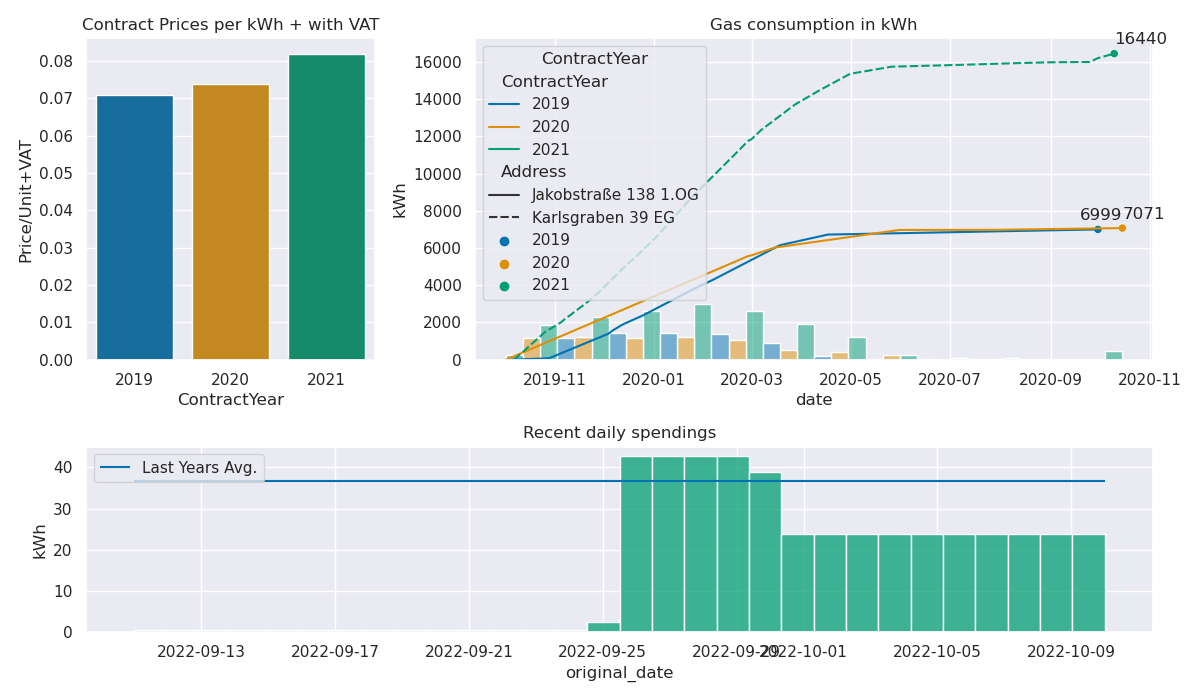

In [6]:
fig = plt.figure(tight_layout=True, figsize=(12, 7))

ax1 = plt.subplot2grid((5, 6), (0, 0), colspan=2, rowspan=3)
ax2 = plt.subplot2grid((5, 6), (0, 2), colspan=4, rowspan=3)
ax3 = plt.subplot2grid((5, 6), (3, 0), colspan=6, rowspan=2)

num_categories = len(contract_df[contract_df['Type'] == 'Strom']['ContractYear'].unique())

# Gas Prices per kWh
ax1.set_title('Contract Prices per kWh + with VAT')
sns.barplot(data=contract_df[contract_df['Type'] == 'Gas'], x='ContractYear', y='Price/Unit+VAT', ax=ax1, palette=palette[:num_categories])

# Gas consumption in kWh
gas_df = annual_df[annual_df['Type'] == 'Gas'].copy()
ax2.set_title('Gas consumption in kWh')
ax2.set_ylabel('kWh')
sns.histplot(data=gas_df, x='date', hue='ContractYear', weights='consumption', bins=12, ax=ax2, multiple='dodge', palette=palette[:num_categories], kde=False, cumulative=False, alpha=0.5)
sns.lineplot(data=gas_df, x='date', y='aggregate_consumption', hue="ContractYear", style='Address', ax=ax2, palette=palette[:num_categories])

gas_last_df = gas_df.groupby('ContractYear').tail(1)
sns.scatterplot(data=gas_last_df, x='date', y='aggregate_consumption', hue="ContractYear", ax=ax2, palette=palette[:num_categories])
for index, row in gas_last_df.iterrows():
    date = row['date']
    if (row['ContractYear'] == 2019):
        date -= pd.Timedelta(11, unit='D')
    agg_consumption = round(row['aggregate_consumption'])
    ax2.text(date, agg_consumption + 500, agg_consumption)

ax3.set_title('Recent daily spendings')
# Last updates
ax3.set_ylabel('kWh')
recend_gas_df = gas_df[gas_df['ContractYear'] == 2021].tail(30).copy()
sns.histplot(data=recend_gas_df, x='original_date', weights='consumption', ax=ax3, palette=palette[:num_categories], bins=recend_gas_df.shape[0], color=palette[2])

# Average consumption from previous years per day
avg_usage = np.average(gas_df[(gas_df['date'] <= '2020-03-01') & (gas_df['ContractYear'] != 2021)]['consumption'])
min_time = recend_gas_df['original_date'].min()
max_time = xmax=recend_gas_df['original_date'].max()
ax3.hlines(xmin=min_time, xmax=max_time, y=avg_usage, label='Last Years Avg.')

# Temperature
weather_df = pd.read_csv('aachen_hourly_weather.csv')
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
weather_df = weather_df[(weather_df['datetime'] >= min_time) & (weather_df['datetime'] <= max_time)]
sns.lineplot(data=weather_df, x='datetime', y='temp', ax=ax3, label='Temperature', color='yellow')

plt.legend(loc='upper left')

plt.tight_layout()